
==> Bearbeite Dyn1
✅ Gewählte Datei: C:\Users\G00550\Desktop\Elias\Auswertung R151 Sprinter\schmaler korrigiert\dyn1\r10\V4_T21_R10.txt
🕒 t₀ = 67.875 s (Target travelled 10.66 m along path)
🕒 t_end = 76.966 s
✅ VUT innerhalb Toleranz: True
✅ Target innerhalb Toleranz: True


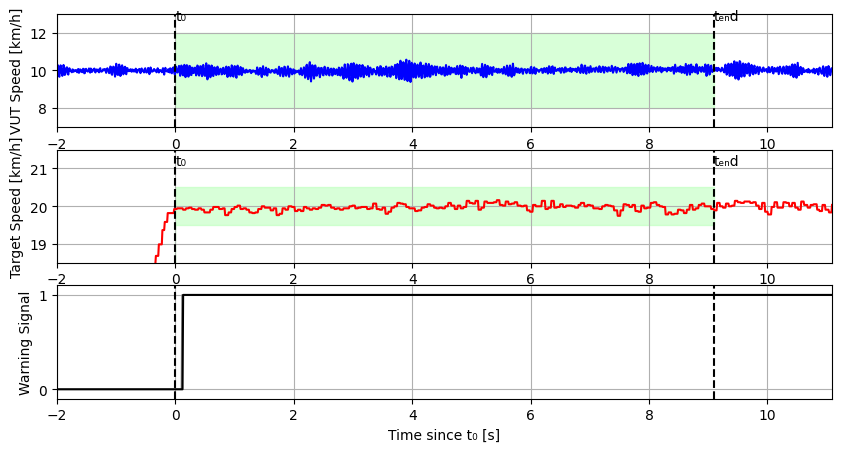

In [ ]:
# Python-Entsprechung (Basisstruktur) deines MATLAB-Skripts
# %matplotlib widget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import io  # ← notwendig für BytesIO
from datetime import datetime
from pathlib import Path
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

# === KONFIGURATION ===
vehicle_class = "M1"  # "M1" oder "N1"
vehicle_load = "beladen"  # "beladen" oder "unbeladen"
vehicle_ref_x = 1.7
vehicle_ref_y = 0
target_ref_x = -3.6
target_ref_y = 0

target_acc_distance = 10.66  # Meter

test_cases = ["Dyn1"]
print_plots = True
logo_path = Path(r"C:\Users\G00550\Desktop\Elias Daten\MATLAB\LOGO\DEKRA_Logo_1000.png")

if logo_path.exists():
    logo_img = Image.open(logo_path).convert("RGB")
    logo_arr = np.array(logo_img)
    threshold = 90
    mask = np.all(logo_arr < threshold, axis=2)
    logo_arr[mask] = [255, 255, 255]
    logo_img = Image.fromarray(logo_arr)
    new_size = tuple(int(dim * 20) for dim in logo_img.size)
    # logo_img = logo_img.resize(new_size, Image.BILINEAR)
    logo_img = logo_img.resize((800, 120), Image.BILINEAR)

# === Testfalldefinition ===
test_case_config = {
    "Dyn1": {
        "file_path": Path(r"C:\Users\G00550\Desktop\Elias\Auswertung R151 Sprinter\schmaler korrigiert\dyn1\r10\V4_T21_R10.txt"),
        "speed_vut_tc": 10,
        "speed_target_tc": 20,
        "scenario_type": "stationary",
        "scenario_string": "Dyn1 - VUT 40 km/h - 100% Overlap",
        "da": -44.4,
        "db": -15.8,
        "dc": -15.0,
        "dd": -26.1,
        "tolDa": 0.5,
        "tol": 0.5,
        # "targetAccDistance": 10.66,  # m
        "VUTCP": 6.0,                # m
        "yTargetResult": -2.5        # m
        
    }
}



for test_case in test_cases:
    print(f"\n==> Bearbeite {test_case}")
    config = test_case_config[test_case]
    speed_vut_tc = config["speed_vut_tc"]
    speed_target_tc = config["speed_target_tc"]
    scenario_type = config["scenario_type"]
    scenario_string = config["scenario_string"]
    file_path = config["file_path"]

    if not file_path.exists():
        print(f"❌ Datei nicht gefunden: {file_path}")
        continue
    print(f"✅ Gewählte Datei: {file_path}")

    # === Datei einlesen ===
    with open(file_path, 'r', encoding='latin1') as f:
        lines = f.readlines()
    header_line_index = max(i for i, line in enumerate(lines) if 'Point' in line)
    raw_header = lines[header_line_index].strip().split('\t')
    clean_header = []
    seen = set()
    for h in raw_header:
        h_clean = h.replace('"', '').strip()
        suffix = 1
        original = h_clean
        while h_clean in seen:
            h_clean = f"{original}_dup{suffix}"
            suffix += 1
        seen.add(h_clean)
        clean_header.append(h_clean)

    data = pd.read_csv(
        file_path,
        sep='\t',
        skiprows=header_line_index + 3,
        names=clean_header,
        decimal=',',
        encoding='latin1',
        engine='python'
    )

    date_run = lines[2].replace("Date=", "").strip()
    time = data['Time'].values
    x_pos_vut = data['MpXPosition'].values
    y_pos_vut = data['MpYPosition'].values
    x_pos_vut_ref = x_pos_vut + vehicle_ref_x
    y_pos_vut_ref = y_pos_vut + vehicle_ref_y

    x_pos_target = data['OtherVehicleXPositionFrontAxle'].values
    y_pos_target = data['OtherVehicleYPositionFrontAxle'].values
    x_pos_target_ref = x_pos_target + target_ref_x
    y_pos_target_ref = y_pos_target + target_ref_y

    distance_ref_x = np.abs(x_pos_target_ref - x_pos_vut_ref)
    vel_vut = data['Speed'].values / 3.6
    vel_target = data['OtherVehicleForwardVelocity'].values
    v_rel = vel_vut - vel_target
    speed_vut = data['Speed'].values
    speed_target = vel_target * 3.6
    # acc_filtered = data['Forward acceleration'].rolling(10, min_periods=1).mean().values
    
    date_line = next((line for line in lines if line.strip().startswith("Date=")), "Date=")
    date_run = date_line.replace("Date=", "").strip()
    # return data, date_run

    # === Toleranzen ===
    vutTol = 2;         # VUT ± 2 km/h
    targetTol = 0.5    # Target ± 0.5 km/h
    relVelTol = 2.5   # Relative velocity tolerance in km/h
    tolLatTarget = 0.2
    tolLatVUT = 0.5
    xRefTarget = 0.793
    yRefTarget = 0.25
    xRefVUT = 1.027
    yRefVUT = -1.01
    yVUTResult = -1.01
    
    
    da = config["da"]
    db = config["db"]
    dc = config["dc"]
    dd = config["dd"]
    tolDa = config["tolDa"]
    tol = config["tol"]
    # targetAccDistance = config["targetAccDistance"]
    VUTCP = config["VUTCP"]
    yTargetResult = config["yTargetResult"]

    
    # === t₀-Ermittlung: Target hat Beschleunigungsweg 5,66 m zurückgelegt ===
    
    target_x_start = x_pos_target[0]
    target_dist = x_pos_target - target_x_start

    idx_t0 = np.argmax(target_dist >= target_acc_distance)
    if target_dist[idx_t0] < target_acc_distance:
        raise ValueError(f"❌ Target hat keine Distanz von {target_acc_distance:.2f} m zurückgelegt.")
    t_0 = time[idx_t0]
    print(f"🕒 t₀ = {t_0:.3f} s (Target travelled {target_acc_distance:.2f} m along path)")

    # === t_end-Ermittlung ===
    idx_end = np.argmax(x_pos_vut > 1)
    if x_pos_vut[idx_end] <= 1:
        t_end = t_0 + 8
    else:
        t_end = max(t_0 + 8, time[idx_end])
    print(f"🕒 t_end = {t_end:.3f} s")

    # === Zeitbereich für Plots definieren ===
    t_plot_start = -2
    t_plot_end = t_end - t_0 + 2
    t_rel = time - t_0
    idx_plot = np.where((t_rel >= t_plot_start) & (t_rel <= t_plot_end))[0]
    t_rel_plot = t_rel[idx_plot]

    # === Geschwindigkeit extrahieren für Plotbereich ===
    vut_speed_plot = speed_vut[idx_plot]
    target_speed_plot = speed_target[idx_plot]
    
        # === Toleranzprüfungen ===
    idx_in_window = np.where((t_rel_plot >= 0) & (t_rel_plot <= (t_end - t_0)))[0]
    within_tol_vut = np.all(np.abs(vut_speed_plot[idx_in_window] - speed_vut_tc) <= vutTol)
    within_tol_target = np.all(np.abs(target_speed_plot[idx_in_window] - speed_target_tc) <= targetTol)
    
    if within_tol_vut:
        print(f"✅ VUT innerhalb Toleranz: {within_tol_vut}")
    else:    
        print(f"❌ VUT innerhalb Toleranz: {within_tol_vut}")
    
    if within_tol_target:
        print(f"✅ Target innerhalb Toleranz: {within_tol_target}")
    else:    
        print(f"❌ Target innerhalb Toleranz: {within_tol_target}")
        
    # === Indizes für t₀ und t_end im globalen Zeitarray ===
    idx_t0_global = np.argmin(np.abs(time - t_0))
    idx_tend_global = np.argmin(np.abs(time - t_end))

    # === X-Positionen zum Zeitpunkt t₀ und t_end ===
    x_vut_t0 = x_pos_vut_ref[idx_t0_global]
    x_vut_tend = x_pos_vut_ref[idx_tend_global]
    x_target_t0 = x_pos_target_ref[idx_t0_global]
    x_target_tend = x_pos_target_ref[idx_tend_global]

    # === Y-Positionen
    y_vut = data['ThisVehicleYPositionReference'].values
    y_vut_plot = y_vut[idx_plot]

    # Für verschiedene Testfälle Target-Y-Quelle wechseln
    if test_case in ["AdditionalTestCase1", "AdditionalTestCase2"]:
        y_target = data['OtherVehicleYPositionReference'].values
        y_target_plot = y_target[idx_plot]
    else:
        y_target = data['OtherVehicleYPositionFrontAxle'].values
        y_target_plot = y_target[idx_plot]

    # Referenzanpassung der Y-Positionen
    y_targetRef_plot = y_target_plot + yRefTarget - yRefVUT
    y_targetRef = y_target + yRefTarget - yRefVUT
    y_vutRef_plot = y_vut_plot - yRefVUT
    y_vutRef = y_vut - yRefVUT

    # === X-Positionen extrahieren für Plot
    x_vut_plot = data['ThisVehicleXPositionReference'].values[idx_plot]
    x_target_plot = data['Object1XPositionReference'].values[idx_plot]

    # === Warnsignal glätten und binär machen
    warnsignal = data['CanDecode2'].values[idx_plot]
    window_size = 5
    warnsignal_smooth = pd.Series(warnsignal).rolling(window=window_size, min_periods=1).mean().values
    warnsignal_filtered = warnsignal_smooth > 0.5

    # === X-Position (relativ zum Crashpunkt)
    x_vut_neg = data['ThisVehicleXPositionReference'].values[idx_plot]

    # === Aktivierungsbereich setzen
    x_start = min(dc, dd)
    x_end = max(dc, dd)

    # === Erste Aktivierung prüfen
    first_idx = np.argmax(warnsignal_filtered)
    if warnsignal_filtered[first_idx] != 1:
        first_idx = None

    if first_idx is not None:
        x_first = x_vut_neg[first_idx]
        if x_start <= x_first <= x_end:
            color_shade = (0.7, 1.0, 0.7)  # hellgrün
        else:
            color_shade = (1.0, 0.8, 0.8)  # hellrot
    else:
        color_shade = (1.0, 0.8, 0.8)      # hellrot

    # === Distanzen berechnen
    vut_x2dist = data['ThisVehicleXPositionReference'].values - data['ThisVehicleXPositionReference'].values[0]
    vut_dist_test = x_vut_tend - x_vut_t0
    vut_x_start_abs = abs(data['ThisVehicleXPositionReference'].values[0] - x_vut_t0)
    vut_x_end_abs = vut_x_start_abs + vut_dist_test
    vut_dist_end = data['ThisVehicleXPositionReference'].values[-1]

    tar_x2dist = data['OtherVehicleXPositionReference'].values - data['OtherVehicleXPositionReference'].values[0]
    target_dist_test = x_target_tend - x_target_t0
    target_dist_test_end = target_acc_distance + target_dist_test

    # === Logo laden und Hintergrund anpassen
    logo_image = np.array(Image.open(r"C:\Users\G00550\Desktop\Elias Daten\MATLAB\LOGO\logoDekra2800.png").convert("RGB"))
    mask = np.all(logo_image < 90, axis=2)
    logo_image[mask] = [255, 255, 255]
    logo_image = Image.fromarray(logo_image).resize((800, 120), Image.BILINEAR)

    # === Sammelplot 1 ===
    # fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    # fig.suptitle("Übersichtsplot: Geschwindigkeiten & Warnsignal", fontsize=14)
    fig = plt.figure(num=1001, figsize=(10, 5))
    fig.clf()  # Inhalt der Figure löschen

    # Subplots manuell erzeugen (da plt.subplots() neue Figure macht!)
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2, sharex=ax1)
    ax3 = fig.add_subplot(3, 1, 3, sharex=ax1)

    axs = [ax1, ax2, ax3]


    # === Subplot 1: VUT Speed ===
    ax1 = axs[0]
    xfill = [0, t_end - t_0]
    yfill_vut = [speed_vut_tc - vutTol, speed_vut_tc + vutTol]
    ax1.fill(
        [xfill[0], xfill[1], xfill[1], xfill[0]],
        [yfill_vut[0], yfill_vut[0], yfill_vut[1], yfill_vut[1]],
        color=(0.7, 1.0, 0.7) if within_tol_vut else (1.0, 0.8, 0.8),
        alpha=0.5
    )
    ax1.plot(t_rel, speed_vut, 'b', linewidth=1.5, label="VUT Speed")
    ax1.axvline(0, color='k', linestyle='--')
    ax1.text(0, yfill_vut[1] + 0.5, "t₀", va='bottom', ha='left')
    ax1.axvline(t_end - t_0, color='k', linestyle='--')
    ax1.text(t_end - t_0, yfill_vut[1] + 0.5, "tₑₙd", va='bottom', ha='left')
    ax1.set_ylabel("VUT Speed [km/h]")
    ax1.set_xlim(t_plot_start, t_plot_end)
    ax1.set_ylim(speed_vut_tc - vutTol - 1, speed_vut_tc + vutTol + 1)
    ax1.grid(True)

    # === Subplot 2: Target Speed ===
    ax2 = axs[1]
    yfill_target = [speed_target_tc - targetTol, speed_target_tc + targetTol]
    ax2.fill_between(
        [xfill[0], xfill[1], xfill[1], xfill[0]],
        [yfill_target[0], yfill_target[0], yfill_target[1], yfill_target[1]],
        color=(0.7, 1.0, 0.7) if within_tol_target else (1.0, 0.8, 0.8),
        alpha=0.5
    )
    ax2.plot(t_rel, speed_target, 'r', linewidth=1.5, label="Target Speed")
    ax2.axvline(0, color='k', linestyle='--')
    ax2.text(0, yfill_target[1] + 0.5, "t₀", va='bottom', ha='left')
    ax2.axvline(t_end - t_0, color='k', linestyle='--')
    ax2.text(t_end - t_0, yfill_target[1] + 0.5, "tₑₙd", va='bottom', ha='left')
    ax2.set_ylabel("Target Speed [km/h]")
    ax2.set_xlim(t_plot_start, t_plot_end)
    ax2.set_ylim(speed_target_tc - targetTol - 1, speed_target_tc + targetTol + 1)
    ax2.grid(True)

    # === Subplot 3: Warnsignal (Raw & Gefiltert) ===
    ax3 = axs[2]
    ax3.plot(t_rel_plot, warnsignal, color='gray', linewidth=1, label='Raw Signal')
    ax3.plot(t_rel_plot, warnsignal_filtered, 'k', linewidth=1.5, label='Filtered Signal')
    ax3.axvline(0, color='k', linestyle='--', label='t₀')
    ax3.axvline(t_end - t_0, color='k', linestyle='--', label='tₑₙd')
    ax3.set_xlabel("Time since t₀ [s]")
    ax3.set_ylabel("Warning Signal")
    ax3.set_xlim(t_plot_start, t_plot_end)
    ax3.set_ylim(-0.1, 1.1)
    ax3.set_yticks([0, 1])
    ax3.grid(True)
    
 
    